In [16]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the .mat file (adjust path to where you saved it)
file_path = '../data/NASA/B0025.mat'  # Update this!
mat_data = sio.loadmat(file_path)
# Extract the battery data (usually under a key like 'B0005')
battery_data = mat_data['B0025'][0, 0]['cycle'][0]


Cycle 3: Raw capacity = [[array([[1.84701116]])]]
Cycle 5: Raw capacity = [[array([[1.84856543]])]]
Cycle 7: Raw capacity = [[array([[1.84711118]])]]
Cycle 9: Raw capacity = [[array([[1.84898376]])]]
Cycle 11: Raw capacity = [[array([[1.83701207]])]]
Cycle 15: Raw capacity = [[array([[1.81754921]])]]
Cycle 19: Raw capacity = [[array([[1.83986382]])]]
Cycle 22: Raw capacity = [[array([[1.84305956]])]]
Cycle 24: Raw capacity = [[array([[1.84018717]])]]
Cycle 26: Raw capacity = [[array([[1.82812656]])]]
Cycle 30: Raw capacity = [[array([[1.82535633]])]]
Cycle 34: Raw capacity = [[array([[1.82141806]])]]
Cycle 36: Raw capacity = [[array([[1.83031563]])]]
Cycle 38: Raw capacity = [[array([[1.81754916]])]]
Cycle 40: Raw capacity = [[array([[1.8109012]])]]
Cycle 42: Raw capacity = [[array([[1.80830326]])]]
Cycle 46: Raw capacity = [[array([[1.79280161]])]]
Cycle 50: Raw capacity = [[array([[1.81256315]])]]
Cycle 52: Raw capacity = [[array([[1.80777261]])]]
Cycle 54: Raw capacity = [[array([[1

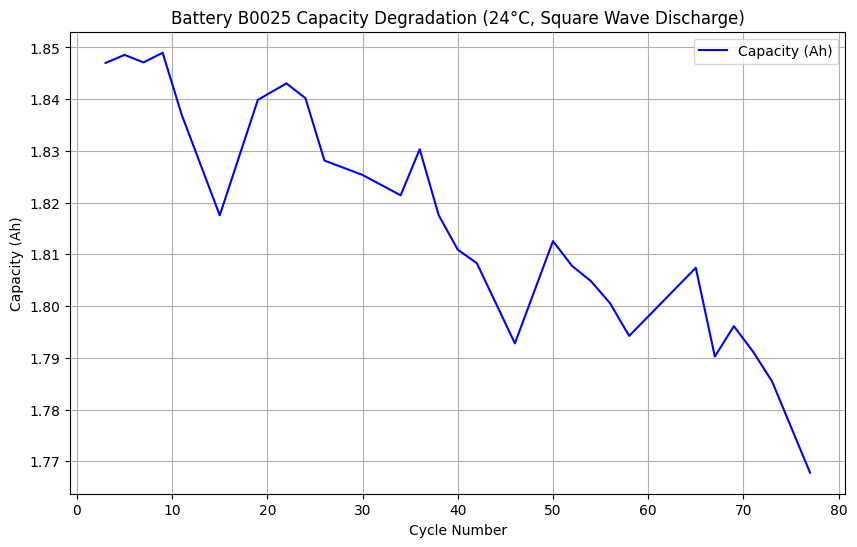

In [7]:
# Pull out capacity and cycle numbers
cycles = []
capacities = []
for i, cycle in enumerate(battery_data):
    if cycle['type'][0] == 'discharge':
        cycles.append(i)
        # Get raw capacity
        raw_capacity = cycle['data']['Capacity']
        # Debug print
        print(f"Cycle {i}: Raw capacity = {raw_capacity}")
        # Extract scalar: dig through nested arrays
        capacity_scalar = raw_capacity[0][0][0][0]  # Unwrap all layers
        capacities.append(capacity_scalar)

# Print stats
print(f"Loaded {len(cycles)} discharge cycles.")
print(f"Initial capacity: {capacities[0]:.3f} Ah")
print(f"Final capacity: {capacities[-1]:.3f} Ah")

# Plot degradation trend
plt.figure(figsize=(10, 6))
plt.plot(cycles, capacities, 'b-', label='Capacity (Ah)')
plt.xlabel('Cycle Number')
plt.ylabel('Capacity (Ah)')
plt.title('Battery B0025 Capacity Degradation (24°C, Square Wave Discharge)')
plt.grid(True)
plt.legend()
plt.show()

Loaded 168 discharge cycles.
Initial capacity: 1.856 Ah
Final capacity: 1.325 Ah
Estimated failure cycle: 101 (capacity ~1.4752095869031632:.3f Ah)
RUL at cycle 0: 100 cycles


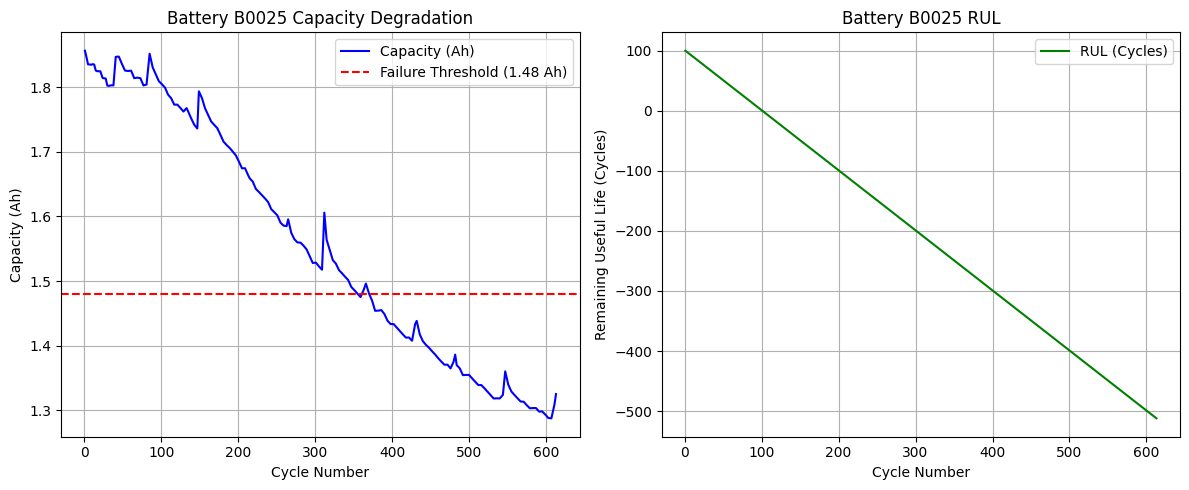

In [20]:
# Load the .mat file (adjust path to where you saved it)
file_path = '../data/NASA/B0005.mat'  # Update this!
mat_data = sio.loadmat(file_path)
# Extract the battery data (usually under a key like 'B0005')
battery_data = mat_data['B0005'][0, 0]['cycle'][0]

cycles = []
capacities = []
for i, cycle in enumerate(battery_data):
    if cycle['type'][0] == 'discharge':
        cycles.append(i)
        raw_capacity = cycle['data']['Capacity']
        capacity_scalar = raw_capacity[0][0][0][0]  # Unwrap nested array
        capacities.append(capacity_scalar)

# Define failure threshold (80% of initial ~1.85 Ah)
failure_threshold = 1.48  # Adjust if needed
failure_cycle = -1
for i, cap in enumerate(capacities):
    if cap <= failure_threshold:
        failure_cycle = i
        break

if failure_cycle == -1:
    print("Battery didn't reach failure threshold in 80 cycles. Extend or adjust threshold.")
    failure_cycle = len(cycles)  # Use last cycle as proxy

# Calculate RUL for each cycle
ruls = [failure_cycle - i for i in cycles]

# Print stats
print(f"Loaded {len(cycles)} discharge cycles.")
print(f"Initial capacity: {capacities[0]:.3f} Ah")
print(f"Final capacity: {capacities[-1]:.3f} Ah")
print(f"Estimated failure cycle: {failure_cycle} (capacity ~{capacities[failure_cycle] if failure_cycle < len(capacities) else 'N/A'}:.3f Ah)")
print(f"RUL at cycle 0: {ruls[0]} cycles")

# Plot capacity and RUL
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cycles, capacities, 'b-', label='Capacity (Ah)')
plt.axhline(y=failure_threshold, color='r', linestyle='--', label='Failure Threshold (1.48 Ah)')
plt.xlabel('Cycle Number')
plt.ylabel('Capacity (Ah)')
plt.title('Battery B0025 Capacity Degradation')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cycles, ruls, 'g-', label='RUL (Cycles)')
plt.xlabel('Cycle Number')
plt.ylabel('Remaining Useful Life (Cycles)')
plt.title('Battery B0025 RUL')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Cycle 1 - Type: discharge, Time: [[2.0080e+03 4.0000e+00 2.0000e+00 1.5000e+01 2.5000e+01 4.1593e+01]]
Cycle 3 - Type: discharge, Time: [[2.0080e+03 4.0000e+00 2.0000e+00 1.9000e+01 4.3000e+01 4.8406e+01]]
Cycle 5 - Type: discharge, Time: [[2.008e+03 4.000e+00 3.000e+00 0.000e+00 1.000e+00 6.687e+00]]
Cycle 7 - Type: discharge, Time: [[2008.       4.       3.       4.      16.      37.375]]
Cycle 9 - Type: discharge, Time: [[2008.       4.       3.       8.      33.      25.703]]
Cycle 11 - Type: discharge, Time: [[2008.       4.       3.      12.      55.      10.687]]
Cycle 13 - Type: discharge, Time: [[2008.       4.       3.      17.      17.      16.015]]
Cycle 15 - Type: discharge, Time: [[2008.       4.       3.      21.      28.      14.718]]
Cycle 17 - Type: discharge, Time: [[2.0080e+03 4.0000e+00 4.0000e+00 1.0000e+00 3.8000e+01 1.5218e+01]]
Cycle 19 - Type: discharge, Time: [[2008.       4.       4.       5.      48.       8.609]]
Cycle 21 - Type: discharge, Time: [[2008.  

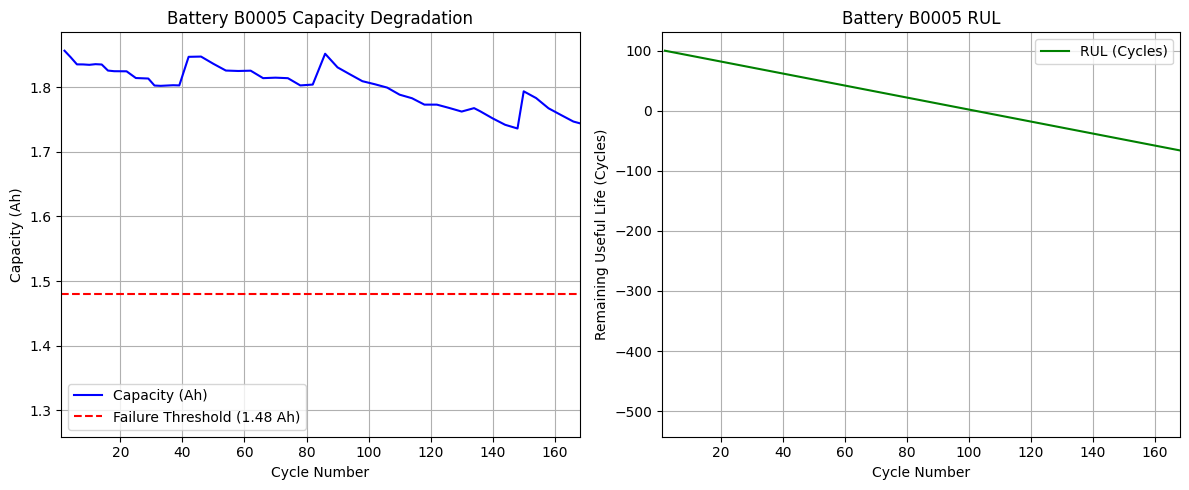

Data saved to B0005_processed.csv


In [26]:
file_path = '../data/NASA/B0005.mat'  # Update this!
mat_data = sio.loadmat(file_path)
# Extract discharge data and verify cycle numbers
cycles = []
voltages = []
currents = []
temps = []
capacities = []
for i, cycle in enumerate(battery_data):
    if cycle['type'][0] == 'discharge':
        # Debug: Print cycle details
        print(f"Cycle {i} - Type: {cycle['type'][0]}, Time: {cycle['time']}")
        cycles.append(i + 1)  # 1-based cycle number
        data = cycle['data']
        voltages.append(np.mean(data['Voltage_measured'][0]))  # Average voltage
        currents.append(np.mean(data['Current_measured'][0]))  # Average current
        temps.append(np.mean(data['Temperature_measured'][0]))  # Average temp
        raw_capacity = data['Capacity']
        capacity_scalar = raw_capacity[0][0][0][0]  # Unwrap nested array
        capacities.append(capacity_scalar)

# Create DataFrame with explicit cycle range
df = pd.DataFrame({
    'Cycle': cycles,  # Should be 1 to 168
    'Voltage (V)': voltages,
    'Current (A)': currents,
    'Temperature (°C)': temps,
    'Capacity (Ah)': capacities
})

# Calculate RUL (failure at 1.48 Ah)
failure_threshold = 1.48
failure_cycle = -1
for i, cap in enumerate(capacities):
    if cap <= failure_threshold:
        failure_cycle = i
        break

if failure_cycle == -1:
    print("Battery didn't reach failure threshold. Using last cycle as proxy.")
    failure_cycle = len(cycles) - 1

df['RUL (Cycles)'] = [failure_cycle - (c - 1) for c in cycles]  # Adjust for 1-based indexing

# Print stats
print(f"Loaded {len(cycles)} discharge cycles.")
print(f"Initial capacity: {capacities[0]:.3f} Ah")
print(f"Final capacity: {capacities[-1]:.3f} Ah")
print(f"Failure cycle: {failure_cycle + 1} (capacity ~{capacities[failure_cycle]:.3f} Ah)")  # 1-based

# Plot capacity and RUL with explicit x-limits
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(df['Cycle'], df['Capacity (Ah)'], 'b-', label='Capacity (Ah)')
plt.axhline(y=failure_threshold, color='r', linestyle='--', label='Failure Threshold (1.48 Ah)')
plt.xlabel('Cycle Number')
plt.ylabel('Capacity (Ah)')
plt.title('Battery B0005 Capacity Degradation')
plt.grid(True)
plt.legend()
plt.xlim(1, len(cycles))  # Force x-axis to match cycle count (1 to 168)

plt.subplot(1, 2, 2)
plt.plot(df['Cycle'], df['RUL (Cycles)'], 'g-', label='RUL (Cycles)')
plt.xlabel('Cycle Number')
plt.ylabel('Remaining Useful Life (Cycles)')
plt.title('Battery B0005 RUL')
plt.grid(True)
plt.legend()
plt.xlim(1, len(cycles))  # Force x-axis to match cycle count (1 to 168)

plt.tight_layout()
plt.show()

# Save DataFrame for modeling
df.to_csv('../data/NASA/preprocessed/B0005_processed.csv', index=False)
print("Data saved to B0005_processed.csv")